In [1]:
# [CELL 1] - Install & Import Libraries
# Cài đặt thư viện XGBoost (thường Colab có sẵn, nhưng chạy cho chắc)
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb # Thư viện chính

# Các module hỗ trợ
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Cấu hình hiển thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Đã sẵn sàng với XGBoost!")

✅ Đã sẵn sàng với XGBoost!


In [2]:
# [CELL 2] - Load Final Dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/processed_data_2+3/Final_Training_Data.csv"
# (Lưu ý: Hãy sửa lại đường dẫn nếu bạn lưu chỗ khác)

try:
    df = pd.read_csv(file_path)
    print(f"✅ Đã load dữ liệu thành công! Tổng số mẫu: {df.shape[0]}")
    display(df.head())
except Exception as e:
    print(f"❌ Lỗi load file: {e}")

✅ Đã load dữ liệu thành công! Tổng số mẫu: 7025


,Image_Name,Original_Class,Pct_Green,Pct_Yellow,Pct_Brown,Derived_Color,Soil_Moisture,Sunlight_Hours,Final_Label
0,c9e13908-bce6-4ad7-831f-a4a408cabf72___JR_B.Sp...,Pepper__bell___Bacterial_spot,20.484279,32.461785,15.614432,Nau/Dom,18.830000,6.100000,Sau_benh
1,cc74b411-3662-41cf-9764-517ddfa1e913___NREC_B....,Pepper__bell___Bacterial_spot,28.254640,5.157929,40.013025,Nau/Dom,25.203149,6.433506,Sau_benh
2,02baf62e-11e2-4dde-97fb-e369b57d55d3___JR_B.Sp...,Pepper__bell___Bacterial_spot,90.127891,2.575333,1.094954,Xanh,25.431516,8.984180,Can_tuoi
3,018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Sp...,Pepper__bell___Bacterial_spot,63.707666,2.925868,4.987892,Nau/Dom,11.836693,8.876882,Sau_benh
4,cbb8c960-5659-4bf1-b75e-f5b2e65b7c0b___NREC_B....,Pepper__bell___Bacterial_spot,61.582585,1.230390,1.316431,Xanh,26.569299,10.980044,Can_tuoi


In [3]:
# [CELL 3] - Data Encoding (Chuyển chữ thành số)

# 1. Định nghĩa Input (X) và Output (y)
features = ['Derived_Color', 'Soil_Moisture', 'Sunlight_Hours']
target = 'Final_Label'

X_raw = df[features].copy()
y_raw = df[target].copy()

# 2. Mã hóa Input (Màu sắc)
color_map = {'Xanh': 0, 'Vang': 1, 'Nau/Dom': 2}
X = X_raw.copy()
X['Derived_Color'] = X['Derived_Color'].map(color_map)
X.rename(columns={'Derived_Color': 'Derived_Color_Encoded'}, inplace=True)

# 3. Mã hóa Output (Nhãn dự đoán) - XGBoost bắt buộc nhãn phải là số từ 0
# Ta dùng LabelEncoder tự động hoặc Map thủ công
label_map = {'Tot': 0, 'Can_tuoi': 1, 'Heo': 2, 'Sau_benh': 3}
y = y_raw.map(label_map)

print("✅ Dữ liệu X sau mã hóa:")
print(X.head())
print("\n✅ Dữ liệu y sau mã hóa:")
print(y.value_counts())

✅ Dữ liệu X sau mã hóa:
   Derived_Color_Encoded  Soil_Moisture  Sunlight_Hours
0                      2      18.830000        6.100000
1                      2      25.203149        6.433506
2                      0      25.431516        8.984180
3                      2      11.836693        8.876882
4                      0      26.569299       10.980044

✅ Dữ liệu y sau mã hóa:
Final_Label
3    3765
0    1280
2    1177
1     803
Name: count, dtype: int64


In [4]:
# [CELL 4] - Split Train/Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 Tập Train: {X_train.shape}")
print(f"📊 Tập Test:  {X_test.shape}")

📊 Tập Train: (5620, 3)
📊 Tập Test:  (1405, 3)


In [5]:
# [CELL 5] - Train XGBoost Model
print("🚀 Đang huấn luyện mô hình XGBoost...")

# Khởi tạo mô hình
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss' # Hàm mất mát cho phân loại đa lớp
)

# Bắt đầu học
xgb_model.fit(X_train, y_train)

print("✅ Huấn luyện hoàn tất!")

🚀 Đang huấn luyện mô hình XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Huấn luyện hoàn tất!


In [6]:
# [CELL 6] - Model Evaluation
y_pred = xgb_model.predict(X_test)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"🏆 ĐỘ CHÍNH XÁC (ACCURACY): {accuracy * 100:.2f}%")
print("-" * 50)

# Để in báo cáo đẹp, ta cần lấy lại tên nhãn gốc (Tot, Heo...)
target_names = ['Tot', 'Can_tuoi', 'Heo', 'Sau_benh'] # Theo thứ tự 0,1,2,3
print("BÁO CÁO CHI TIẾT:")
print(classification_report(y_test, y_pred, target_names=target_names))

🏆 ĐỘ CHÍNH XÁC (ACCURACY): 88.33%
--------------------------------------------------
BÁO CÁO CHI TIẾT:
              precision    recall  f1-score   support

         Tot       1.00      1.00      1.00       256
    Can_tuoi       1.00      1.00      1.00       161
         Heo       0.83      0.38      0.52       235
    Sau_benh       0.83      0.98      0.90       753

    accuracy                           0.88      1405
   macro avg       0.92      0.84      0.86      1405
weighted avg       0.88      0.88      0.87      1405



In [7]:
# [CELL 7] - K-Fold Cross Validation (Kiểm tra độ ổn định)
print("🔄 Đang chạy Cross-Validation (5 lần)...")

# Khởi tạo bộ chia 5 phần
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Chạy kiểm thử
cv_results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='accuracy')

print(f"📊 Kết quả 5 lần chạy: {cv_results}")
print(f"⭐ Độ chính xác trung bình: {cv_results.mean() * 100:.2f}%")
print(f"📉 Độ lệch chuẩn (Sai số): {cv_results.std():.4f}")

if cv_results.mean() > 0.95:
    print("👉 KẾT LUẬN: Model hoạt động cực kỳ ổn định và chính xác!")

🔄 Đang chạy Cross-Validation (5 lần)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:12:32] WARNING: /w

📊 Kết quả 5 lần chạy: [0.87829181 0.87330961 0.87615658 0.8747331  0.86619217]
⭐ Độ chính xác trung bình: 87.37%
📉 Độ lệch chuẩn (Sai số): 0.0041


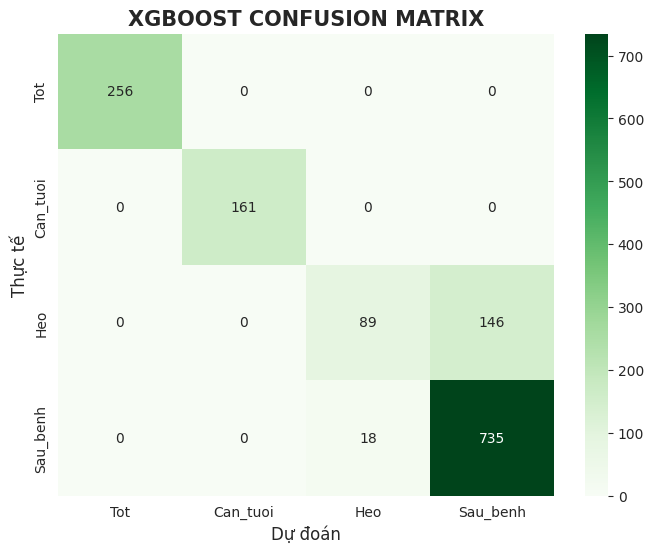

In [8]:
# [CELL 8] - Visualize Confusion Matrix
plt.figure(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Đổi màu Xanh lá cho hợp mệnh Mộc (Cây)
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('XGBOOST CONFUSION MATRIX', fontsize=15, fontweight='bold')
plt.xlabel('Dự đoán', fontsize=12)
plt.ylabel('Thực tế', fontsize=12)
plt.show()

/tmp/ipython-input-1951941988.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='magma')


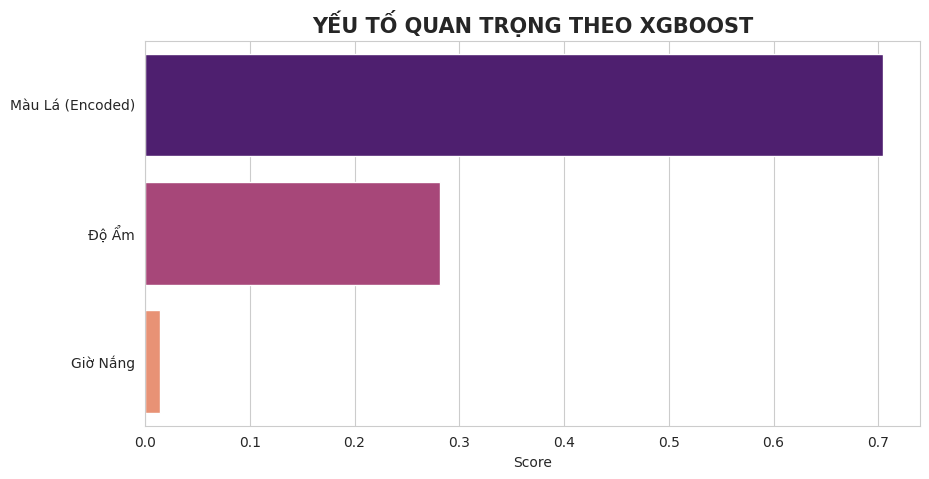

In [9]:
# [CELL 9] - Feature Importance
plt.figure(figsize=(10, 5))

# Lấy độ quan trọng
importances = xgb_model.feature_importances_
feature_names = ['Màu Lá (Encoded)', 'Độ Ẩm', 'Giờ Nắng']

sns.barplot(x=importances, y=feature_names, palette='magma')
plt.title('YẾU TỐ QUAN TRỌNG THEO XGBOOST', fontsize=15, fontweight='bold')
plt.xlabel('Score')
plt.show()